In [1]:
import pandas as pd
import geopandas as gp
import os
from helper_functions import *
pd.options.display.max_columns = 100


#Raw election results from state
df = pd.read_table("./raw-from-source/results_pct_20221108.txt", sep = "\t")
#RDH created PBER file
pber = gp.read_file("./nc_2022_gen_prec/nc_2022_gen_prec.shp")
#2022 NC State leg plans
sldl = gp.read_file("./nc_sldl_adopted_2022/SL 2022-4.shp")


#Standardize district col in district gdfs
sldl['SL_DIST']=sldl["DISTRICT"].astype(str).str.zfill(3)


#Make district gdf crs match pber gdf to enable overlay
sldl = sldl.to_crs(pber.crs)


#District gdfs - to be modified
pber["SLDL_DIST"] = "NA"
pber_sldl = pber[["UNIQUE_ID","COUNTYFP","COUNTYNM","PRECINCT", "SLDL_DIST"]+list(pber.columns[(pber.columns.str.contains("GSL"))])+["geometry"]]

In [2]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one
    
def get_level_dist(column_name):
    if column_name[0:4] == "GSLP":
        level = "SL"
        dist = "004"
    elif column_name[0:3] == "GSL":
        level = "SL"
        dist = column_name[3:6]
    elif column_name[0:3] == "GCO":
        level = "CON"
        dist = column_name[4:6]
    else:
        print(column_name)
        raise ValueError
    return level,dist

def contains_sldl(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "SL":
            return dist_tuple[1]
        

#PH sldl dist code
def return_sldl(row):
    for val in races:
        if row[val] != 0:
            return val[3:6]
        
           
from collections import Counter
races = [i for i in list(pber_sldl.columns) if "GSL" in i]
precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in pber_sldl.iterrows():
    precinct_list = []
    for contest in races:
        if(row[contest]!=0):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["UNIQUE_ID"]]=is_split
    precinct_mapping_dict[row["UNIQUE_ID"]]=precinct_list
    

pber_sldl["SLDL_DIST"] = pber_sldl.apply(lambda row: return_sldl(row), axis = 1)
split_precincts_list

/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


{'CRAVEN---02': {'SL': ['003', '013']},
 'ROBESON---11': {'SL': ['046', '047']},
 'CABARRUS---12-14': {'SL': ['073', '083']},
 'MECKLENBURG---PCT 133': {'SL': ['098', '106']},
 'ROBESON---14': {'SL': ['046', '047']},
 'WAYNE---15': {'SL': ['004', '010']},
 'WAYNE---16': {'SL': ['004', '010']},
 'ROBESON---30': {'SL': ['046', '047']},
 'ROBESON---36': {'SL': ['046', '047']},
 'IREDELL---BA-1': {'SL': ['084', '095']},
 'BRUNSWICK---CB05': {'SL': ['017', '019']},
 'GRANVILLE---CRDM': {'SL': ['007', '032']},
 'DARE---KILL DEVIL HILLS': {'SL': ['001', '079']},
 'HARNETT---PR32': {'SL': ['006', '053']},
 'BRUNSWICK---SB01': {'SL': ['017', '019']}}

In [3]:
pber_sldl[pber_sldl['SLDL_DIST'].isna()]

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,SLDL_DIST,GSL001RGOO,GSL002DJEF,GSL002LBEL,GSL002RYAR,GSL003RTYS,GSL004DBOY,GSL004RDIX,GSL005DIII,GSL005RWAR,GSL006DJOH,GSL006RPIK,GSL007RWIN,GSL008DBRO,GSL008RVIN,GSL009DFAR,GSL009RREE,GSL010RBEL,GSL011DDAH,GSL012DWIL,GSL012RHUM,GSL013DTOM,GSL013RCAI,GSL014DJOH,GSL014RCLE,GSL015DSCH,GSL015RSHE,GSL016RSMI,GSL017DTER,GSL017RILE,GSL018DBUT,GSL018RHIN,GSL019RMIL,GSL020DDEL,GSL020RDAV,GSL021DLIU,GSL021LMOR,GSL021RFAL,GSL022RBRI,GSL023DWIL,GSL023RPRO,GSL024DCOO,GSL024RFON,GSL025DGAI,GSL025LTAY,GSL025RCHE,...,GSL092RROB,GSL093DMAS,GSL093RPIC,GSL094DHUB,GSL094RELM,GSL095DKOT,GSL095RMIL,GSL096RADA,GSL097RSAI,GSL098DCLA,GSL098RBRA,GSL099DMAJ,GSL099RAND,GSL100DAUT,GSL101DLOG,GSL101RMAU,GSL102DCAR,GSL102RCLE,GSL103DBUD,GSL103RBRA,GSL104DLOF,GSL104RPOM,GSL105DHAR,GSL105RNID,GSL106DCUN,GSL106RHEN,GSL107DALE,GSL107RCOO,GSL108RTOR,GSL109DHUG,GSL109RLOF,GSL110RHAS,GSL111RMOO,GSL112DCOT,GSL112RLON,GSL113RJOH,GSL114DAGE,GSL114RPIT,GSL115DPRA,GSL115RBHA,GSL116DRUD,GSL116RROS,GSL117DOSH,GSL117RBAL,GSL118DREM,GSL118RPLE,GSL119DPLA,GSL119RCLA,GSL120RGIL,geometry


In [4]:
for val in pber_sldl["UNIQUE_ID"]:
    cd_list = []
    if val in split_precincts_list.keys():
        print(val)
        join_attempt_1 = district_splits_mod(split_precincts_list[val],"SLDL",val, pber_sldl, sldl, "UNIQUE_ID", "SL_DIST", races, "SLDL_DIST")

CRAVEN---02
ROBESON---11
CABARRUS---12-14
MECKLENBURG---PCT 133
ROBESON---14
WAYNE---15
WAYNE---16
ROBESON---30
ROBESON---36
IREDELL---BA-1
BRUNSWICK---CB05
GRANVILLE---CRDM
DARE---KILL DEVIL HILLS
HARNETT---PR32
BRUNSWICK---SB01


In [5]:
join_attempt_1[join_attempt_1['SLDL_DIST'].isna()]

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,SLDL_DIST,GSL001RGOO,GSL002DJEF,GSL002LBEL,GSL002RYAR,GSL003RTYS,GSL004DBOY,GSL004RDIX,GSL005DIII,GSL005RWAR,GSL006DJOH,GSL006RPIK,GSL007RWIN,GSL008DBRO,GSL008RVIN,GSL009DFAR,GSL009RREE,GSL010RBEL,GSL011DDAH,GSL012DWIL,GSL012RHUM,GSL013DTOM,GSL013RCAI,GSL014DJOH,GSL014RCLE,GSL015DSCH,GSL015RSHE,GSL016RSMI,GSL017DTER,GSL017RILE,GSL018DBUT,GSL018RHIN,GSL019RMIL,GSL020DDEL,GSL020RDAV,GSL021DLIU,GSL021LMOR,GSL021RFAL,GSL022RBRI,GSL023DWIL,GSL023RPRO,GSL024DCOO,GSL024RFON,GSL025DGAI,GSL025LTAY,GSL025RCHE,...,GSL092RROB,GSL093DMAS,GSL093RPIC,GSL094DHUB,GSL094RELM,GSL095DKOT,GSL095RMIL,GSL096RADA,GSL097RSAI,GSL098DCLA,GSL098RBRA,GSL099DMAJ,GSL099RAND,GSL100DAUT,GSL101DLOG,GSL101RMAU,GSL102DCAR,GSL102RCLE,GSL103DBUD,GSL103RBRA,GSL104DLOF,GSL104RPOM,GSL105DHAR,GSL105RNID,GSL106DCUN,GSL106RHEN,GSL107DALE,GSL107RCOO,GSL108RTOR,GSL109DHUG,GSL109RLOF,GSL110RHAS,GSL111RMOO,GSL112DCOT,GSL112RLON,GSL113RJOH,GSL114DAGE,GSL114RPIT,GSL115DPRA,GSL115RBHA,GSL116DRUD,GSL116RROS,GSL117DOSH,GSL117RBAL,GSL118DREM,GSL118RPLE,GSL119DPLA,GSL119RCLA,GSL120RGIL,geometry


In [6]:
join_attempt_1[join_attempt_1['geometry'].isna()]

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,SLDL_DIST,GSL001RGOO,GSL002DJEF,GSL002LBEL,GSL002RYAR,GSL003RTYS,GSL004DBOY,GSL004RDIX,GSL005DIII,GSL005RWAR,GSL006DJOH,GSL006RPIK,GSL007RWIN,GSL008DBRO,GSL008RVIN,GSL009DFAR,GSL009RREE,GSL010RBEL,GSL011DDAH,GSL012DWIL,GSL012RHUM,GSL013DTOM,GSL013RCAI,GSL014DJOH,GSL014RCLE,GSL015DSCH,GSL015RSHE,GSL016RSMI,GSL017DTER,GSL017RILE,GSL018DBUT,GSL018RHIN,GSL019RMIL,GSL020DDEL,GSL020RDAV,GSL021DLIU,GSL021LMOR,GSL021RFAL,GSL022RBRI,GSL023DWIL,GSL023RPRO,GSL024DCOO,GSL024RFON,GSL025DGAI,GSL025LTAY,GSL025RCHE,...,GSL092RROB,GSL093DMAS,GSL093RPIC,GSL094DHUB,GSL094RELM,GSL095DKOT,GSL095RMIL,GSL096RADA,GSL097RSAI,GSL098DCLA,GSL098RBRA,GSL099DMAJ,GSL099RAND,GSL100DAUT,GSL101DLOG,GSL101RMAU,GSL102DCAR,GSL102RCLE,GSL103DBUD,GSL103RBRA,GSL104DLOF,GSL104RPOM,GSL105DHAR,GSL105RNID,GSL106DCUN,GSL106RHEN,GSL107DALE,GSL107RCOO,GSL108RTOR,GSL109DHUG,GSL109RLOF,GSL110RHAS,GSL111RMOO,GSL112DCOT,GSL112RLON,GSL113RJOH,GSL114DAGE,GSL114RPIT,GSL115DPRA,GSL115RBHA,GSL116DRUD,GSL116RROS,GSL117DOSH,GSL117RBAL,GSL118DREM,GSL118RPLE,GSL119DPLA,GSL119RCLA,GSL120RGIL,geometry


In [7]:
join_attempt_1[join_attempt_1['UNIQUE_ID'].str.contains("SLDL")]

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,SLDL_DIST,GSL001RGOO,GSL002DJEF,GSL002LBEL,GSL002RYAR,GSL003RTYS,GSL004DBOY,GSL004RDIX,GSL005DIII,GSL005RWAR,GSL006DJOH,GSL006RPIK,GSL007RWIN,GSL008DBRO,GSL008RVIN,GSL009DFAR,GSL009RREE,GSL010RBEL,GSL011DDAH,GSL012DWIL,GSL012RHUM,GSL013DTOM,GSL013RCAI,GSL014DJOH,GSL014RCLE,GSL015DSCH,GSL015RSHE,GSL016RSMI,GSL017DTER,GSL017RILE,GSL018DBUT,GSL018RHIN,GSL019RMIL,GSL020DDEL,GSL020RDAV,GSL021DLIU,GSL021LMOR,GSL021RFAL,GSL022RBRI,GSL023DWIL,GSL023RPRO,GSL024DCOO,GSL024RFON,GSL025DGAI,GSL025LTAY,GSL025RCHE,...,GSL092RROB,GSL093DMAS,GSL093RPIC,GSL094DHUB,GSL094RELM,GSL095DKOT,GSL095RMIL,GSL096RADA,GSL097RSAI,GSL098DCLA,GSL098RBRA,GSL099DMAJ,GSL099RAND,GSL100DAUT,GSL101DLOG,GSL101RMAU,GSL102DCAR,GSL102RCLE,GSL103DBUD,GSL103RBRA,GSL104DLOF,GSL104RPOM,GSL105DHAR,GSL105RNID,GSL106DCUN,GSL106RHEN,GSL107DALE,GSL107RCOO,GSL108RTOR,GSL109DHUG,GSL109RLOF,GSL110RHAS,GSL111RMOO,GSL112DCOT,GSL112RLON,GSL113RJOH,GSL114DAGE,GSL114RPIT,GSL115DPRA,GSL115RBHA,GSL116DRUD,GSL116RROS,GSL117DOSH,GSL117RBAL,GSL118DREM,GSL118RPLE,GSL119DPLA,GSL119RCLA,GSL120RGIL,geometry
2654,BRUNSWICK---SB01-(SLDL-019),19,BRUNSWICK,SB01,019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,618,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((2241002.761 104385.968, 224082..."
2655,BRUNSWICK---SB01-(SLDL-017),19,BRUNSWICK,SB01,017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,147,81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((2243598.898 103688.774, 224315..."


In [8]:
join_attempt_1.shape

(2656, 222)

### Totals Checks

In [9]:
county_totals_check(pber, "pber", join_attempt_1, "join",races, "COUNTYFP")
statewide_totals_check(pber, "pber", join_attempt_1, "join",races)

***Countywide Totals Check***

GSL001RGOO is equal across all counties
GSL002DJEF is equal across all counties
GSL002LBEL is equal across all counties
GSL002RYAR is equal across all counties
GSL003RTYS is equal across all counties
GSL004DBOY is equal across all counties
GSL004RDIX is equal across all counties
GSL005DIII is equal across all counties
GSL005RWAR is equal across all counties
GSL006DJOH is equal across all counties
GSL006RPIK is equal across all counties
GSL007RWIN is equal across all counties
GSL008DBRO is equal across all counties
GSL008RVIN is equal across all counties
GSL009DFAR is equal across all counties
GSL009RREE is equal across all counties
GSL010RBEL is equal across all counties
GSL011DDAH is equal across all counties
GSL012DWIL is equal across all counties
GSL012RHUM is equal across all counties
GSL013DTOM is equal across all counties
GSL013RCAI is equal across all counties
GSL014DJOH is equal across all counties
GSL014RCLE is equal across all counties
GSL015DSC

### Check district assignments

In [10]:
## Intersect the District with GA_CONG to fill in the n/a values
na_values = join_attempt_1[join_attempt_1["SLDL_DIST"].isna()]
others = join_attempt_1[~(join_attempt_1["SLDL_DIST"].isna())]

In [11]:
print(join_attempt_1.shape)
print(others.shape)
print(na_values.shape)

(2656, 222)
(2656, 222)
(0, 222)


In [12]:
intersected = gp.overlay(sldl, na_values, how = "intersection")


# Create a dictionary to map
intersected['area'] = intersected.area
na_assignment_dict = {}
for val in intersected["UNIQUE_ID"].unique():

    assignment = intersected.loc[intersected["UNIQUE_ID"] == val].nlargest(1, 'area')["SL_DIST"].values[0]
    na_assignment_dict[val] = assignment

In [13]:
join_attempt_1["SLDL_DIST"].unique()

array(['086', '067', '102', '055', '027', '099', '112', '069', '100',
       '088', '085', '011', '083', '049', '073', '034', '038', '048',
       '033', '066', '114', '008', '023', '010', '101', '075', '107',
       '068', '104', '047', '093', '089', '076', '030', '090', '091',
       '007', '077', '120', '064', '052', '109', '082', '040', '009',
       '003', '036', '111', '046', '041', '116', '113', '081', '087',
       '096', '110', '021', '074', '063', '037', '092', '115', '103',
       '105', '080', '108', '039', '029', '094', '031', '071', '106',
       '098', '004', '001', '054', '035', '013', '079', '005', '072',
       '002', '051', '118', '070', '045', '043', '119', '050', '032',
       '012', '097', '117', '022', '084', '014', '078', '017', '019',
       '056', '044', '095', '042', '018', '016', '057', '015', '065',
       '058', '059', '062', '061', '060', '020', '025', '024', '006',
       '028', '053', '026'], dtype=object)

In [14]:
join_attempt_1["SLDL_DIST"] = join_attempt_1["UNIQUE_ID"].map(na_assignment_dict).fillna(join_attempt_1["SLDL_DIST"])


assigned_districts = join_attempt_1.dissolve(["SLDL_DIST"])
assigned_districts.reset_index(drop=False,inplace=True)


sldl["SLDL_DIST"] = sldl["SL_DIST"]

In [15]:
assigned_districts['SLDL_DIST'].unique()

array(['001', '002', '003', '004', '005', '006', '007', '008', '009',
       '010', '011', '012', '013', '014', '015', '016', '017', '018',
       '019', '020', '021', '022', '023', '024', '025', '026', '027',
       '028', '029', '030', '031', '032', '033', '034', '035', '036',
       '037', '038', '039', '040', '041', '042', '043', '044', '045',
       '046', '047', '048', '049', '050', '051', '052', '053', '054',
       '055', '056', '057', '058', '059', '060', '061', '062', '063',
       '064', '065', '066', '067', '068', '069', '070', '071', '072',
       '073', '074', '075', '076', '077', '078', '079', '080', '081',
       '082', '083', '084', '085', '086', '087', '088', '089', '090',
       '091', '092', '093', '094', '095', '096', '097', '098', '099',
       '100', '101', '102', '103', '104', '105', '106', '107', '108',
       '109', '110', '111', '112', '113', '114', '115', '116', '117',
       '118', '119', '120'], dtype=object)

In [16]:
pd.merge(assigned_districts,sldl,how="outer",on="SLDL_DIST",validate="1:1",indicator=True)

,SLDL_DIST,geometry_x,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,GSL001RGOO,GSL002DJEF,GSL002LBEL,GSL002RYAR,GSL003RTYS,GSL004DBOY,GSL004RDIX,GSL005DIII,GSL005RWAR,GSL006DJOH,GSL006RPIK,GSL007RWIN,GSL008DBRO,GSL008RVIN,GSL009DFAR,GSL009RREE,GSL010RBEL,GSL011DDAH,GSL012DWIL,GSL012RHUM,GSL013DTOM,GSL013RCAI,GSL014DJOH,GSL014RCLE,GSL015DSCH,GSL015RSHE,GSL016RSMI,GSL017DTER,GSL017RILE,GSL018DBUT,GSL018RHIN,GSL019RMIL,GSL020DDEL,GSL020RDAV,GSL021DLIU,GSL021LMOR,GSL021RFAL,GSL022RBRI,GSL023DWIL,GSL023RPRO,GSL024DCOO,GSL024RFON,GSL025DGAI,GSL025LTAY,...,GSL094RELM,GSL095DKOT,GSL095RMIL,GSL096RADA,GSL097RSAI,GSL098DCLA,GSL098RBRA,GSL099DMAJ,GSL099RAND,GSL100DAUT,GSL101DLOG,GSL101RMAU,GSL102DCAR,GSL102RCLE,GSL103DBUD,GSL103RBRA,GSL104DLOF,GSL104RPOM,GSL105DHAR,GSL105RNID,GSL106DCUN,GSL106RHEN,GSL107DALE,GSL107RCOO,GSL108RTOR,GSL109DHUG,GSL109RLOF,GSL110RHAS,GSL111RMOO,GSL112DCOT,GSL112RLON,GSL113RJOH,GSL114DAGE,GSL114RPIT,GSL115DPRA,GSL115RBHA,GSL116DRUD,GSL116RROS,GSL117DOSH,GSL117RBAL,GSL118DREM,GSL118RPLE,GSL119DPLA,GSL119RCLA,GSL120RGIL,DISTRICT,PL20AA_TOT,geometry_y,SL_DIST,_merge
0,001,"POLYGON ((2694406.514 719802.065, 2694306.485 ...",TYRRELL---KILKENNY,177,TYRRELL,KILKENNY,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,84330,"POLYGON ((2676280.806 915462.470, 2676297.242 ...",001,both
1,002,"POLYGON ((2024225.818 828784.324, 2024279.006 ...",DURHAM---23,63,DURHAM,23,0,2937,60,326,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,90751,"POLYGON ((2057644.352 852437.316, 2057662.742 ...",002,both
2,003,"POLYGON ((2567475.491 401112.954, 2567475.258 ...",CRAVEN---02,49,CRAVEN,02,0,0,0,0,762,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,963,1691,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,85099,"POLYGON ((2479809.144 582387.879, 2479833.792 ...",003,both
3,004,"POLYGON ((2306599.064 353233.945, 2306611.438 ...",WAYNE---14,191,WAYNE,14,0,0,0,0,0,495,1421,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,83138,"POLYGON ((2206922.877 560322.540, 2206969.113 ...",004,both
4,005,"POLYGON ((2877020.298 865974.879, 2873934.583 ...",GATES---1,73,GATES,1,0,0,0,0,0,0,0,461,382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,82953,"POLYGON ((2528285.666 913430.084, 2528337.156 ...",005,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,116,"POLYGON ((930807.471 679294.310, 930716.773 67...",BUNCOMBE---04.1,21,BUNCOMBE,04.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,900,141,0,0,0,0,0,0,0,116,90981,"POLYGON ((880339.839 682739.930, 880335.367 68...",116,both
116,117,"POLYGON ((943229.510 531249.981, 943209.570 53...",HENDERSON---ATKINSON,89,HENDERSON,ATKINSON,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,928,1411,0,0,0,0,0,117,90329,"POLYGON ((1028226.217 613995.195, 1028241.733 ...",117,both
117,118,"POLYGON ((815883.753 603407.637, 815805.745 60...",HAYWOOD---ALLENS CREEK,87,HAYW

Checking 120 precincts for differences of greater than 0.1 km^2

1) For 001 difference in area is 0.626969548141175
2) For 003 difference in area is 35.182330607733164
3) For 004 difference in area is 4.981840385345283
4) For 007 difference in area is 9.453562630952808
5) For 010 difference in area is 4.981827248767379
6) For 013 difference in area is 35.18233431410057
7) For 017 difference in area is 4.180039808840509
8) For 019 difference in area is 4.180033724232751
9) For 032 difference in area is 9.453561439633239
10) For 046 difference in area is 11.524871734357301
11) For 047 difference in area is 11.52485536530473
12) For 073 difference in area is 0.5632843339934872
13) For 079 difference in area is 0.6269735358310486
14) For 083 difference in area is 0.5632903211844917
15) For 084 difference in area is 1.5401203629935083
16) For 095 difference in area is 1.5401116761311204
17) For 098 difference in area is 0.2927889303365532
18) For 106 difference in area is 0.2927888775557093

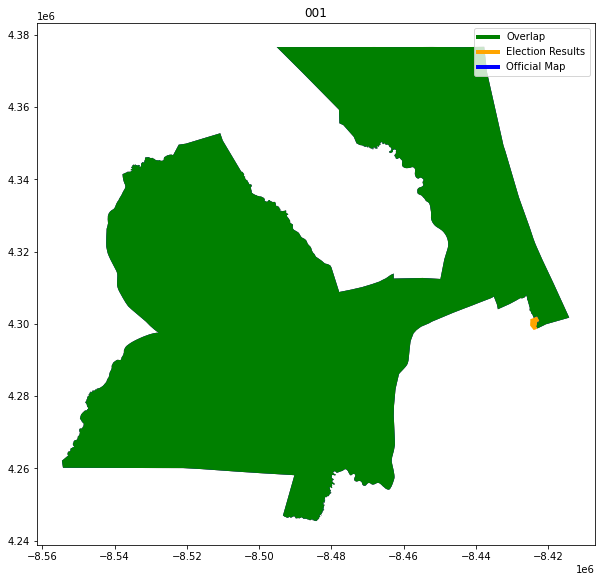

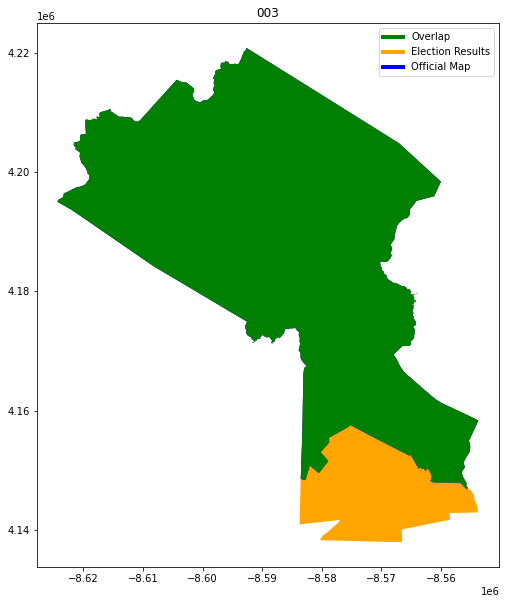

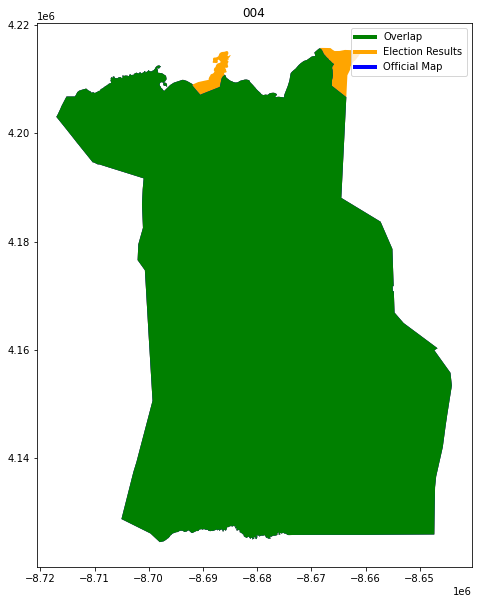

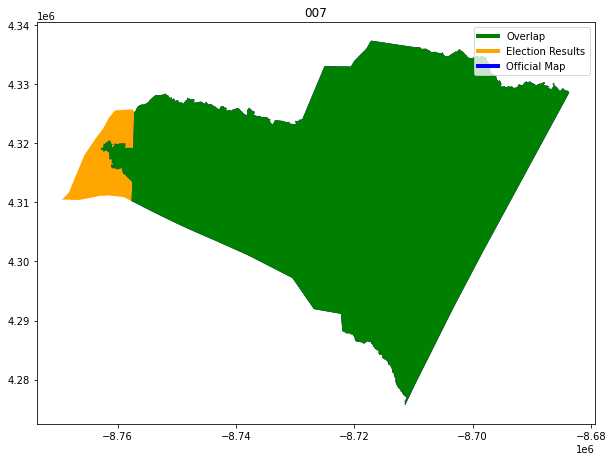

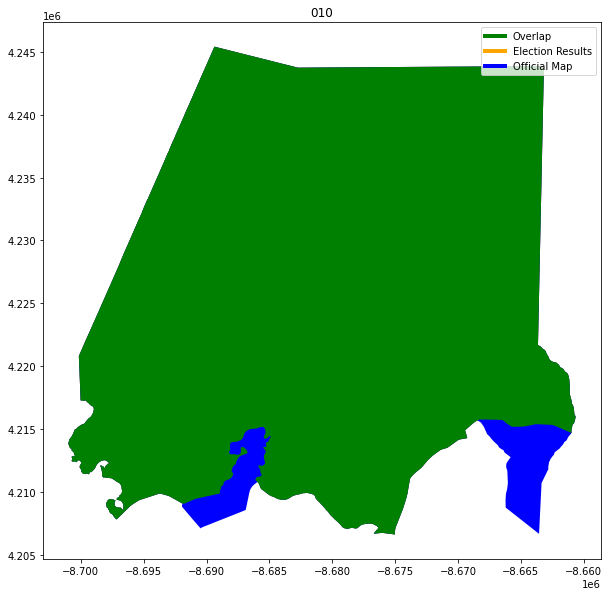

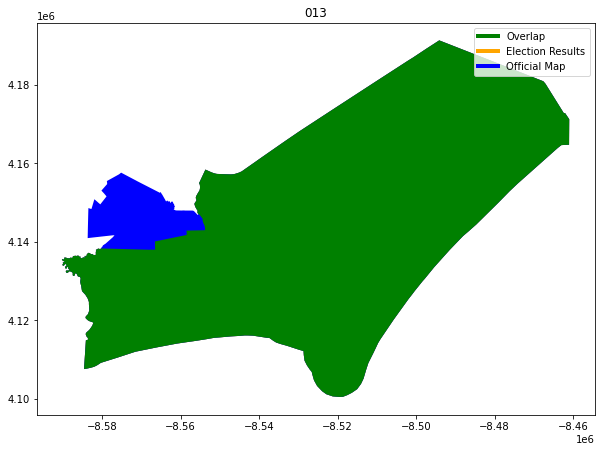

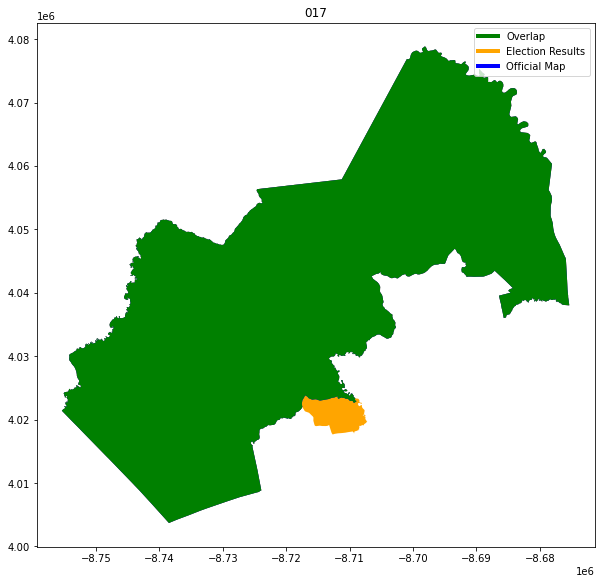

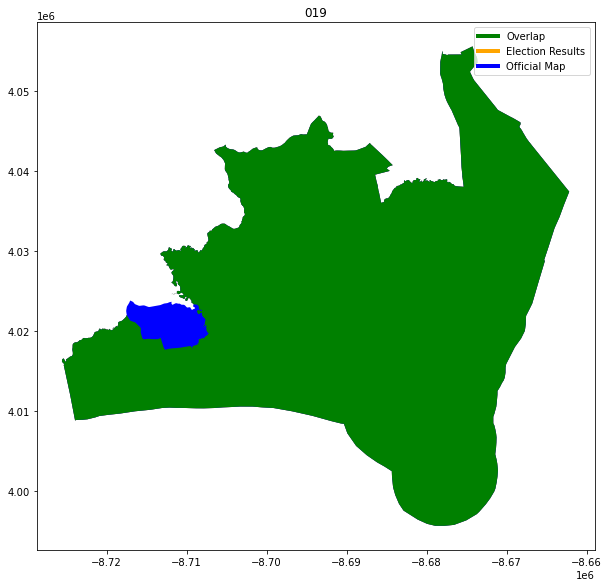

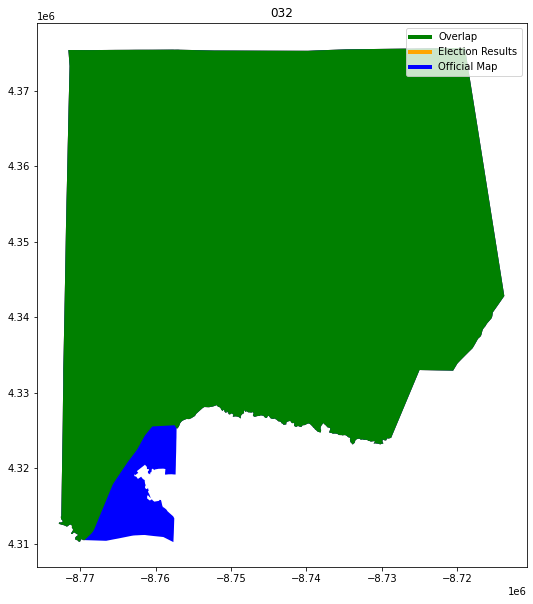

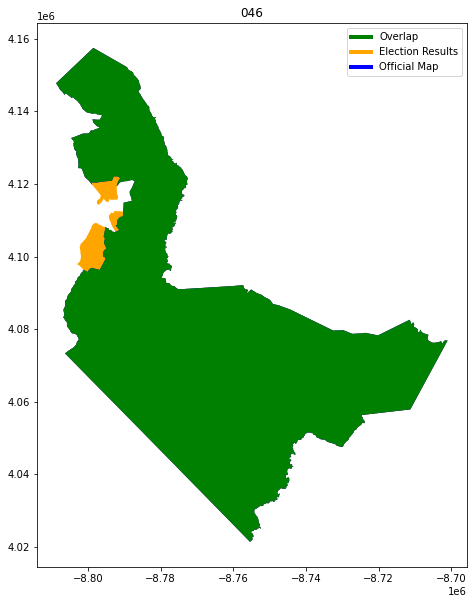

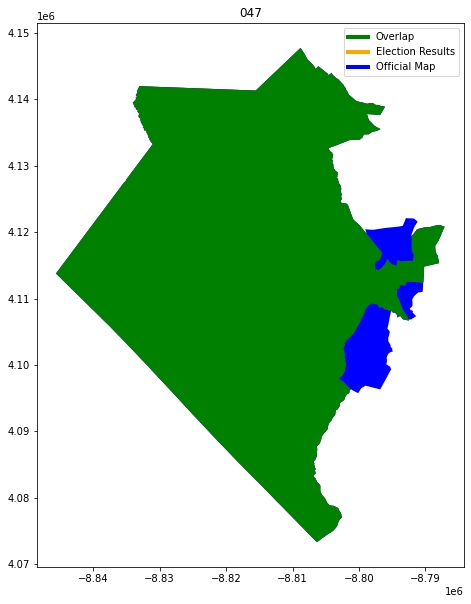

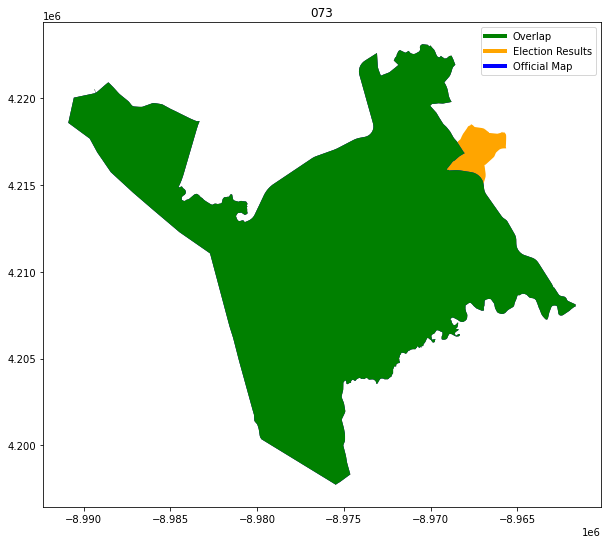

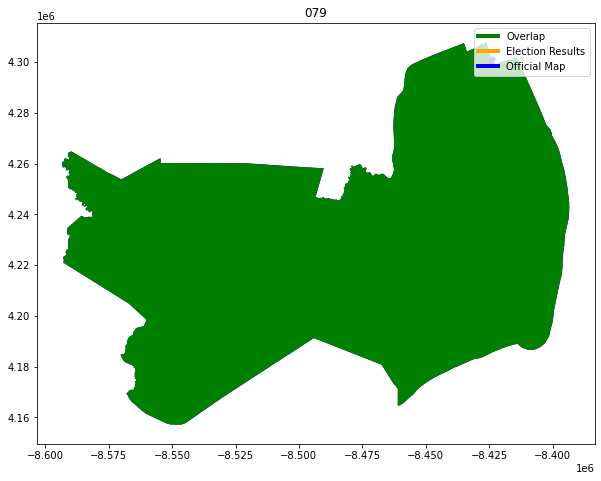

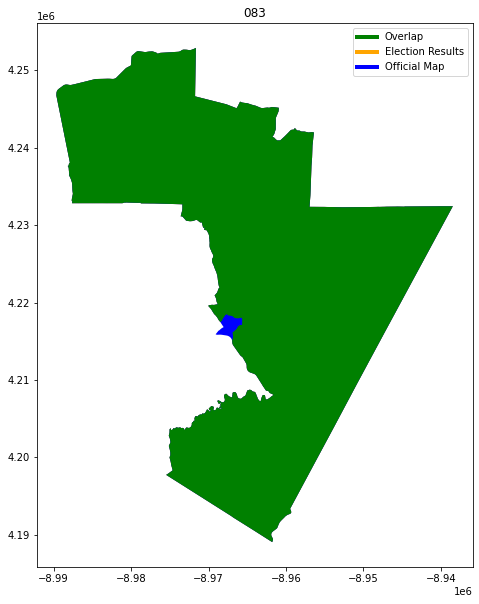

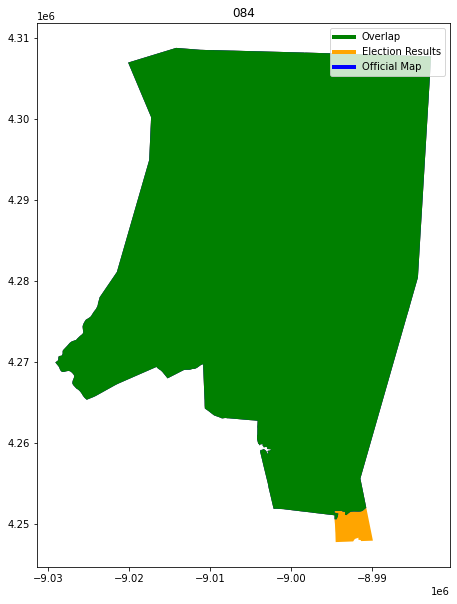

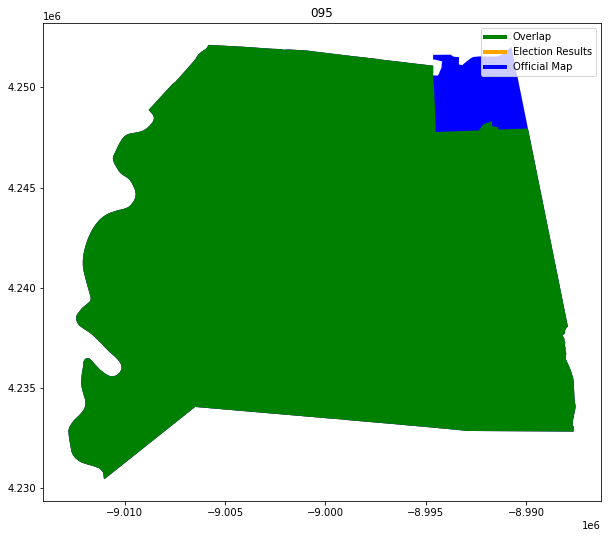

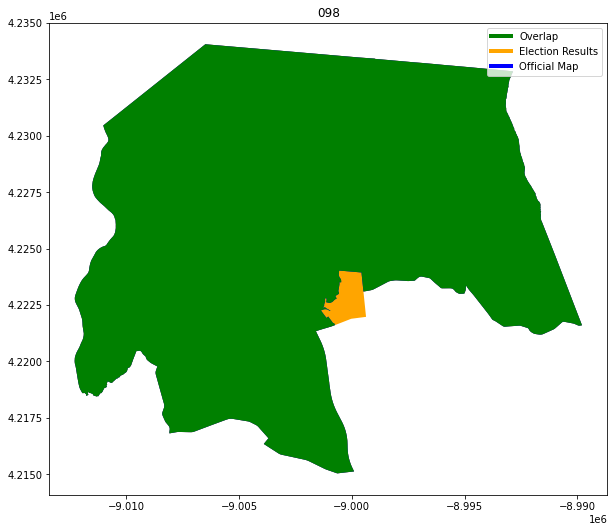

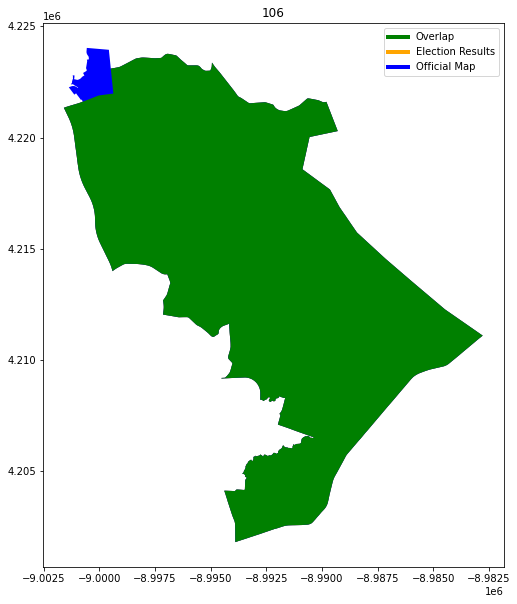

In [17]:
compare_geometries(assigned_districts, sldl,"Election Results", "Official Map", "SLDL_DIST",area_threshold=.1)

## Prepare to export

In [18]:
join_attempt_1

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,SLDL_DIST,GSL001RGOO,GSL002DJEF,GSL002LBEL,GSL002RYAR,GSL003RTYS,GSL004DBOY,GSL004RDIX,GSL005DIII,GSL005RWAR,GSL006DJOH,GSL006RPIK,GSL007RWIN,GSL008DBRO,GSL008RVIN,GSL009DFAR,GSL009RREE,GSL010RBEL,GSL011DDAH,GSL012DWIL,GSL012RHUM,GSL013DTOM,GSL013RCAI,GSL014DJOH,GSL014RCLE,GSL015DSCH,GSL015RSHE,GSL016RSMI,GSL017DTER,GSL017RILE,GSL018DBUT,GSL018RHIN,GSL019RMIL,GSL020DDEL,GSL020RDAV,GSL021DLIU,GSL021LMOR,GSL021RFAL,GSL022RBRI,GSL023DWIL,GSL023RPRO,GSL024DCOO,GSL024RFON,GSL025DGAI,GSL025LTAY,GSL025RCHE,...,GSL092RROB,GSL093DMAS,GSL093RPIC,GSL094DHUB,GSL094RELM,GSL095DKOT,GSL095RMIL,GSL096RADA,GSL097RSAI,GSL098DCLA,GSL098RBRA,GSL099DMAJ,GSL099RAND,GSL100DAUT,GSL101DLOG,GSL101RMAU,GSL102DCAR,GSL102RCLE,GSL103DBUD,GSL103RBRA,GSL104DLOF,GSL104RPOM,GSL105DHAR,GSL105RNID,GSL106DCUN,GSL106RHEN,GSL107DALE,GSL107RCOO,GSL108RTOR,GSL109DHUG,GSL109RLOF,GSL110RHAS,GSL111RMOO,GSL112DCOT,GSL112RLON,GSL113RJOH,GSL114DAGE,GSL114RPIT,GSL115DPRA,GSL115RBHA,GSL116DRUD,GSL116RROS,GSL117DOSH,GSL117RBAL,GSL118DREM,GSL118RPLE,GSL119DPLA,GSL119RCLA,GSL120RGIL,geometry
0,BURKE---0001,23,BURKE,0001,086,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((1233595.464 737538.312, 1233589.172 ..."
1,STANLY---0003,167,STANLY,0003,067,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((1644857.853 584760.831, 1644768.728 ..."
2,BURKE---0003,23,BURKE,0003,086,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((1220715.101 726879.358, 1220723.026 ..."
3,STANLY---0007,167,STANLY,0007,067,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((1650578.509 584607.573, 1650484.945 ..."
4,STANLY---0008,167,STANLY,0008,067,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((1646657.855 579294.538, 1646677.799 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2651,LENOIR---W,107,LENOIR,W,012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70,583,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((2419504.837 485228.828, 2419439.358 ..."
2652,HAYWOOD---WAYNESVILLE WEST,87,HAYWOOD,WAYNESVILLE WEST,118,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,397,513,0,0,0,"POLYGON ((808739.181 660103.212, 808721.741 66..."
2653,CASWELL---YANCEYVILLE,33,CASWELL,YANCEYVILLE,050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((1922279.006 944060.291, 1922142.357 ..."
2654,BRUNSWICK---SB01-(SLDL-019),19,BRUNSWICK,SB01,019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,618,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [19]:
join_attempt_1.to_file("./nc_2022_gen_prec/nc_gen_22_sldl_prec.shp")